In [152]:
import time
from datetime import date
import hashlib
import requests
import hmac
from datetime import datetime
from urllib.parse import urlencode
import os

KEY = 0
SECRET = 0
BASE_URL = "https://api.binance.com"  # production base url
# BASE_URL = 'https://testnet.binance.vision' # testnet base url

def hashing(query_string):
    return hmac.new(
        SECRET.encode("utf-8"), query_string.encode("utf-8"), hashlib.sha256
    ).hexdigest()

def get_timestamp():
    return int(time.time() * 1000)

def to_datetime(timestamp):
    return datetime.fromtimestamp(timestamp / 1000)

def to_timestamp(datetime):
    return int(datetime.timestamp() * 1000)

def send_signed_request(http_method, url_path, payload={}):
    query_string = urlencode(payload, True)
    if query_string:
        query_string = "{}&timestamp={}".format(query_string, get_timestamp())
    else:
        query_string = "timestamp={}".format(get_timestamp())

    url = (
        BASE_URL + url_path + "?" + query_string + "&signature=" + hashing(query_string)
    )
    #print("{} {}".format(http_method, url))
    params = {"url": url, "params": {}}
    response = dispatch_request(http_method)(**params)
    return response.json()

def send_public_request(url_path, payload={}):
    query_string = urlencode(payload, True)
    url = BASE_URL + url_path
    if query_string:
        url = url + "?" + query_string
    #print("{}".format(url))
    response = dispatch_request("GET")(url=url)
    return response.json()

def dispatch_request(http_method):
    session = requests.Session()
    session.headers.update(
        {"Content-Type": "application/json;charset=utf-8", "X-MBX-APIKEY": KEY}
    )
    return {
        "GET": session.get,
        "DELETE": session.delete,
        "PUT": session.put,
        "POST": session.post,
    }.get(http_method, "GET")

In [153]:
def get_day_price(ticker, datetime):
    timestamp = to_timestamp(datetime)
    response = send_public_request("/api/v3/klines", 
                               {"symbol": ticker,
                                "startTime": timestamp,
                                "endTime": timestamp+24*3600*1000,
                                "interval": "1d"
                               })
    return response[0][4]

def get_staking_position():
    return send_signed_request("GET", "/sapi/v1/staking/position")
def get_staking_record():
    return send_signed_request("GET", "/sapi/v1/staking/stakingRecord")


In [155]:
useLocalOrRemoteData = False

if not useLocalOrRemoteData:
    KEY = os.environ.get('somekey1')
    SECRET = os.environ.get('somekey2')
    BASE_URL = "https://api.binance.com"  # production base url
    # BASE_URL = 'https://testnet.binance.vision' # testnet base url

#response = send_signed_request("GET", "/sapi/v1/capital/deposit/hisrec", {'startDate': datetime(2023, 1, 1)})
#response = send_signed_request("GET", "/sapi/v1/eth-staking/eth/history/stakingHistory")
response = send_signed_request("GET", "/sapi/v1/btc-staking/btc/history/stakingHistory")
print(response)
#response = send_signed_request("GET", "/sapi/v1/staking/position")
#print(response)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

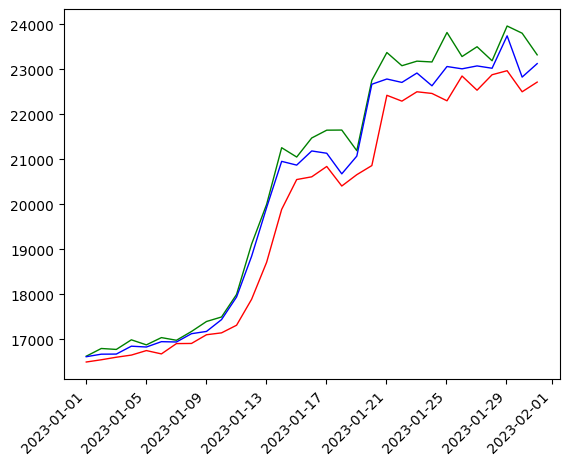

In [156]:
    
#response = send_signed_request("GET", "/api/v3/account")
#print(response)
#print(get_day_price("BTCUSDT", datetime(2023, 1, 1)))
#print(get_staking_position())
#print(get_staking_record())
      
# get klines
beginTime = to_timestamp( datetime(2023, 1, 1))
endTime = to_timestamp( datetime(2023, 2, 1))
response = send_public_request("/api/v3/klines", 
                               {"symbol": "BTCUSDT",
                                "startTime": beginTime,
                                "endTime": endTime,
                                "interval": "1d"})
#print(response)

import pandas as pd
import matplotlib.pyplot as plot

df = pd.DataFrame(response, columns=[
    'Open time',
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "Close time",
    "Quote volume",
    "Number of trades",# of trades"
    "Taker base volume",# volume",  #"buy base asset volume",
    "Taker quote volume",# volume", #"buy quote asset volume", 
    "Ignore"
    ]
)

def row_to_float(df):
    return df.transform(lambda x: float(x))

dataX = df["Open time"].transform(lambda x: to_datetime(x))
plot.plot(dataX,row_to_float(df["High"]), color='green', linewidth=1)
plot.xticks(rotation=45, ha='right')
plot.plot(dataX,row_to_float(df["Low"]), color='red', linewidth=1)
plot.plot(dataX,row_to_float(df["Close"]), color='blue', linewidth=1)


In [ ]:
pd = pd.Dataframe